# LSST Throughputs Curves

The LSST throughputs curves can be found in the [LSST throughputs github repository](https://github.com/lsst/throughputs), or can be installed as an LSST package using 'eups distrib install throughputs'.  More information here on [installing the LSST software stack simulations packages](https://confluence.lsstcorp.org/display/SIM/Code+Overview+--+Catalog+Simulations).

This notebook assumes that throughputs has been installed as a package, as well as sims_photUtils (which is the home of the Sed and Bandpass classes), and that both packages are setup.

----

In [1]:
# Import packages needed.
import os, copy
%matplotlib inline
import matplotlib.pyplot as plt
import lsst.sims.photUtils.Bandpass as Bandpass

The throughputs package contains several directories:

- baseline : this directory contains the current 'expected performance' curves for the LSST system.
- imsim : this directory contains the throughput curves as currently implemented in ImSim ('actual') and the throughput curves that Imsim was using as reference ('goal') (note that imsim, due to development cycles, may sometimes not match the baseline curves)
- atmos : this directory contains standard atmosphere throughput curves at a range of airmasses between 1 and 2.5; the composition of the atmosphere is held constant, while the airmass changes.
- sdss : this directory contains the throughput curves for [SDSS](http://www.sdss.org/instruments/camera/)
- megacam : this directory contains the throughput curves for [CFHT's Megacam](http://www4.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/megapipe/docs/filt.html)
There are README files in each directory with further information about their contents.

The package, when setup, also adds the following environment variables to the user's shell:
- THROUGHPUTS_DIR : points to the root directory of the throughputs package
- LSST_THROUGHPUTS_BASELINE : points to the 'baseline' directory in the throughputs package
- LSST_THROUGHPUTS_DEFAULT : this is a placeholder, that defaults to pointing at the baseline curves. The idea is that you could modify this easily to point to other versions of throughput curves, without having to alter code which is using this environment variable to discover the location of the various throughput curve files.

To generate expected LSST magnitudes, the LSST_THROUGHPUTS_BASELINE set of curves should be used. These curves include an atmosphere with X=1.2, corresponding to the median airmass of the atmosphere expected for LSST observations. 

In [2]:
# Read in the total ('final') throughput curves in each filter, and the atmosphere curve.
filterdir = os.getenv('LSST_THROUGHPUTS_BASELINE')
lsst = {}
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
filtercolors = {'u':'b', 'g':'c', 'r':'g', 'i':'orange', 'z':'r', 'y':'m'}
for f in filterlist:
    lsst[f] = Bandpass()
    lsst[f].readThroughput(os.path.join(filterdir, 'total_'+f+'.dat'))
atmos = Bandpass()
atmos.readThroughput(os.path.join(filterdir, 'atmos_std.dat'))

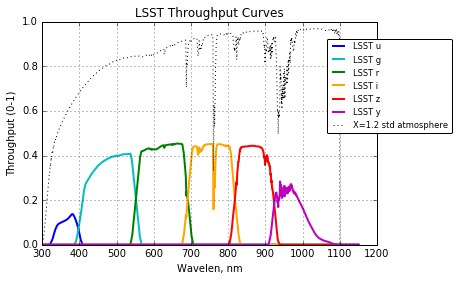

In [3]:
# Plot these curves alone.
for f in filterlist:
    plt.plot(lsst[f].wavelen, lsst[f].sb, color=filtercolors[f], lw=2, label='LSST %s' % (f))
plt.plot(atmos.wavelen, atmos.sb, 'k:', label='X=1.2 std atmosphere')
plt.xlabel('Wavelen, nm')
plt.ylabel('Throughput (0-1)')
plt.title('LSST Throughput Curves')
plt.legend(loc=(0.85, 0.5), fancybox=True, fontsize='smaller')
plt.grid(True)
plt.savefig(os.path.join(filterdir, 'LSSTfilters.png'), format='png')

---
We may also want to compare these throughput curves with SDSS. 

In [4]:
sdssdir = os.path.join(os.getenv('THROUGHPUTS_DIR'), 'sdss')
sdss = {}
sdsslist = ('u', 'g', 'r', 'i', 'z')
for f in sdsslist:
    sdss[f] = Bandpass()
    sdss[f].readThroughput(os.path.join(sdssdir, 'sdss_'+f+'.dat'))

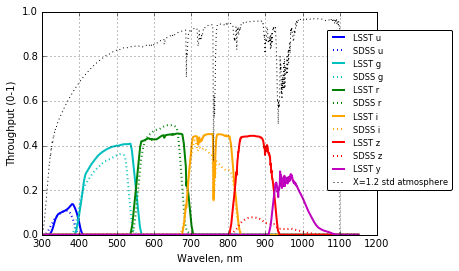

In [5]:
# Plot these curves alone.
for f in filterlist:
    plt.plot(lsst[f].wavelen, lsst[f].sb, color=filtercolors[f], lw=2, label='LSST %s' % (f))
    if f in sdss:
        plt.plot(sdss[f].wavelen, sdss[f].sb, color=filtercolors[f], linestyle=':',  lw=2, label='SDSS %s' % (f))
plt.plot(atmos.wavelen, atmos.sb, 'k:', label='X=1.2 std atmosphere')
plt.xlabel('Wavelen, nm')
plt.ylabel('Throughput (0-1)')
plt.legend(loc=(0.85, 0.2), fancybox=True, fontsize='smaller')
plt.grid(True)

Remembering that the total, above-atmosphere flux $F_b$ is calculated as
\begin{align}
F_b =  \int F_{\nu}(\lambda) \phi(\lambda) d\lambda
\end{align}
where $\phi(\lambda)$, the normalized system response is

\begin{align}
\phi(\lambda) = \frac {S_b(\lambda) / \lambda}{\sum S_b(\lambda) / \lambda}
\end{align}

it is also interesting to plot $\phi(\lambda)$. 

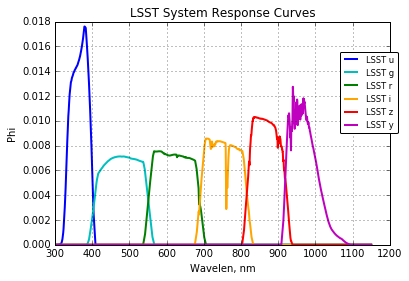

In [6]:
# Plot these curves alone.
for f in filterlist:
    lsst[f].sbTophi()
    plt.plot(lsst[f].wavelen, lsst[f].phi, color=filtercolors[f], lw=2, label='LSST %s' % (f))
plt.xlabel('Wavelen, nm')
plt.ylabel('Phi')
plt.title('LSST System Response Curves')
plt.legend(loc=(0.85, 0.5), fancybox=True, fontsize='smaller')
plt.grid(True)

----

It is also interesting to look at the contributions of the individual components contributing to the final throughput, including the detector QE, the 3 lens transmission curves, the filter transmission curve, the 3 mirror reflectivity curves and the atmosphere transmission.

In [12]:
# Read in each component separately.
allcommon_components = ['detector', 'lens1', 'lens2', 'lens3', 'm1', 'm2', 'm3', 'atmos_std']
allcommon = {}
for c in allcommon_components:
    allcommon[c] = Bandpass()
    allcommon[c].readThroughput(os.path.join(filterdir, c +'.dat'))
# We probably won't want to show each component separately, as the plot will be quite messy. 
#  So let's batch up "mirrors" and "lenses" and the other components we will want to plot.
common = {}
common['detector'] = allcommon['detector']
common['atmosphere'] = allcommon['atmos_std']
common['mirrors'] = copy.deepcopy(allcommon['m1'])
common['mirrors'].sb = allcommon['m1'].sb * allcommon['m2'].sb * allcommon['m3'].sb
common['lenses'] = copy.deepcopy(allcommon['lens1'])
common['lenses'].sb = allcommon['lens1'].sb * allcommon['lens2'].sb * allcommon['lens3'].sb
# Note that we could have also combined these throughput curves using 'Bandpass.readThroughputList'
lsst_filters = {}
for f in filterlist:
    lsst_filters[f] = Bandpass()
    lsst_filters[f].readThroughput(os.path.join(filterdir, 'filter_'+f+'.dat'))

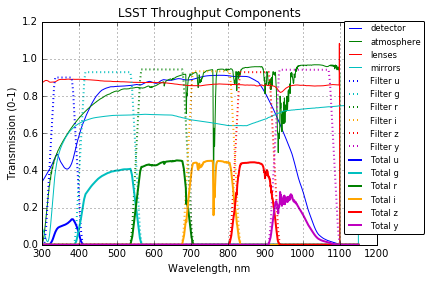

In [13]:
# Make a plot containing the total and component information.
for c in common:
    plt.plot(common[c].wavelen, common[c].sb, label=c)
for f in filterlist:
    plt.plot(lsst_filters[f].wavelen, lsst_filters[f].sb, color=filtercolors[f], linestyle=':', lw=2, label='Filter %s' % (f))
for f in filterlist:
    plt.plot(lsst[f].wavelen, lsst[f].sb, color=filtercolors[f], lw=2, label='Total %s' % (f))
plt.xlabel('Wavelength, nm')
plt.ylabel('Transmission (0-1)')
plt.title('LSST Throughput Components')
plt.legend(loc=(0.9, 0.05), fancybox=True, fontsize='smaller')
plt.grid(True)